In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [4]:
img = imageio.imread('files/three.png')

In [5]:
def noise_like(shape, mean=0, sigma=10):
    return np.random.normal(loc=mean, scale=sigma, size=shape)

In [6]:
noisy_img = img + noise_like(img.shape, sigma=15)

In [7]:
def compare_img(img1, img2):
    fig, axis = plt.subplots(ncols=2, figsize=(10, 8))
    axis[0].imshow(img1, cmap=plt.cm.Greys_r);
    axis[1].imshow(img2, cmap=plt.cm.Greys_r);

def compare_all(original, with_noise, denoised):
    fig, axis = plt.subplots(ncols=3, figsize=(12, 6))
    axis[0].imshow(original, cmap=plt.cm.Greys_r);
    axis[0].set_title("Original image")
    axis[0].axis('off')

    axis[1].imshow(with_noise, cmap=plt.cm.Greys_r);
    axis[1].set_title("Image with noise")
    axis[1].axis('off')

    axis[2].imshow(denoised, cmap=plt.cm.Greys_r)
    axis[2].set_title("2D Fusion LASSO")
    axis[2].axis('off')
    return fig

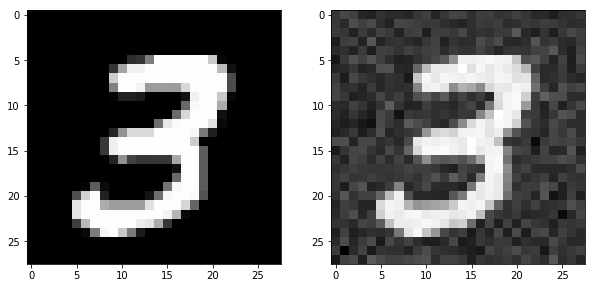

In [8]:
compare_img(img, noisy_img)

2D Fused LASSO problem is:
$$
\min_w \frac{1}{2}\sum^n_{i=1}{(y_i - w_i)^2 + \lambda \sum_{(i, j) \in E}{|w_i - w_j|}}
$$

In [9]:
def mse_loss(y, w):
    return np.sum((y - w) ** 2)

def mse_grad(y, w):
    return w - y

def l1_subgrad(weights, indices):
    """
    l1 is not differentiable, but it's convex, hence we can use subgradient
    """
    sum = np.zeros_like(weights)
    for col in range(indices.shape[1]):
        sum += np.sign(weights - weights[indices[:, col]])
    return sum

def build_adjacency_matrix(shape):
    """
    Adjacency matrix contains indices of neighbour pixels
    """
    x, y = shape
    a = np.zeros((x * y, 4), int)
    for i in range(x):
        for j in range(y):
            ind = i * x + j
            a[ind, 0] = ind if (i - 1) < 0 else x * (i - 1) + j
            a[ind, 1] = ind if (i + 1) >= x else x * (i + 1) + j
            a[ind, 2] = ind if (j - 1) < 0 else x * i + (j - 1)
            a[ind, 3] = ind if (j + 1) >= y else x * i + (j + 1)
    return a

def loss_grad(y, w, adj, alpha=0.01, l=0.3):
    return alpha * mse_grad(y, w) + l * l1_subgrad(w, adj)

def denoise(img, alpha=0.01, l=0.3, n_iter=100, verbose=False, optimizer='vanilla', momentum=0.9):
    """
    Objective is MSE(w) + R(w), where R(w) is absolute difference between values of neighbour pixels
    """
    if optimizer not in ['vanilla', 'momentum', 'nesterov']:
        raise ValueError(f"{optimizer} is not recognized. You can use one of this: 'vanilla', 'momentum', or 'nesterov'")
    img_shape = img.shape
    img = img.ravel()
    weights = np.random.normal(size=(img.shape)) / 100
    delta_weights = np.zeros_like(weights)
    velocity = np.zeros_like(weights)
    adjacency_matrix = build_adjacency_matrix(img_shape)
    for it in range(n_iter):
        if optimizer == 'vanilla':
            weights = weights - loss_grad(img, weights, adjacency_matrix, alpha, l)
        elif optimizer == 'momentum':
            velocity = momentum * velocity + loss_grad(img, weights, adjacency_matrix, alpha, l)
            weights = weights - velocity
        elif optimizer == 'nesterov':
            velocity = momentum * velocity + loss_grad(img, weights - momentum * velocity, adjacency_matrix, alpha, l)
            weights = weights - velocity
        if verbose and it > 0 and it % 100 == 0:
            print(f"{it}: {mse_loss(img, weights)}")
    return weights.reshape(img_shape)

In [10]:
denoised_img = denoise(noisy_img, n_iter=1000, l=0.3, alpha=0.01, optimizer='nesterov')

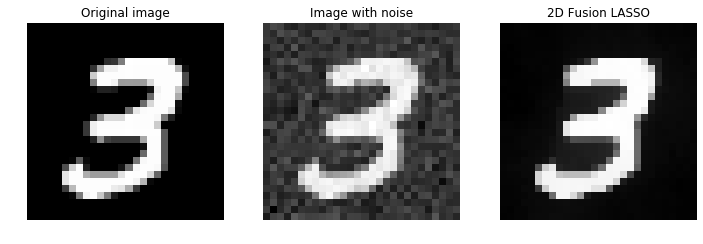

In [11]:
f = compare_all(img, noisy_img, denoised_img)

## Evaluation

It is surprisingly non-trivial task to measure noise in the image. One of the approaches I've found estimates Gaussian noise standard deviation

In [12]:
import skimage
from skimage.restoration import estimate_sigma

def r2_image(image, original=img):
    """
    R^2-like score using estimate of sigma
    
    There are several problems:
    1) Noise can easily be non-gaussian (poisson, s&p, you name it)
    2) value of this metric for original image is 1. How would you interpret it? Complete noise?
    """
    return 1 - (estimate_sigma(image) / estimate_sigma(original))

In [13]:
r2_image(denoised_img), r2_image(noisy_img)

(0.9397523603322071, -0.32585421695606875)

In [15]:
img2 = imageio.imread('files/lena.bmp')

In [16]:
noisy_img2 = np.add(img2, noise_like(img2.shape, sigma=20)).round(0).astype(np.uint8)

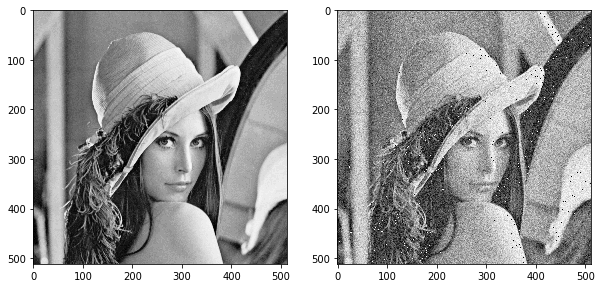

In [17]:
compare_img(img2, noisy_img2)

In [18]:
denoised_img2 = denoise(noisy_img2, n_iter=700, l=1.95, alpha=0.03, verbose=True, optimizer='nesterov')

100: 139363871.2435841
200: 139459485.7860293
300: 139543637.92936623
400: 139565525.55101573
500: 139500445.9425739
600: 139643761.24982026


In [19]:
r2_image(denoised_img2), r2_image(noisy_img2)

(0.7211908361771526, -0.47828944483707647)

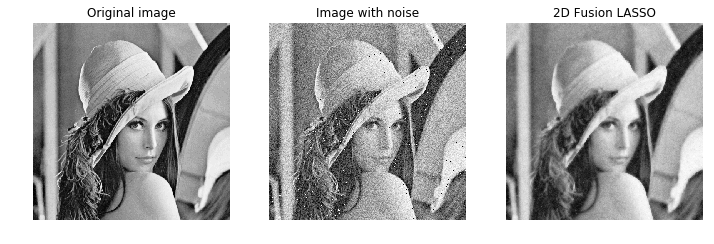

In [20]:
f = compare_all(img2, noisy_img2, denoised_img2)